In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm

C:\Users\cyun9\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Env():
    def __init__(self, n_action):
        self.n_action = n_action 
        self.init_states()

    def init_states(self):
        # 실제 Optimal q value 생성
        self.optimal_q_value_list = [np.random.normal(loc = 0, scale = 1) for i in range(self.n_action)]

    def get_reward(self, action:int):
        '''
        - Desc - 
        Action 값을 넣었을 때 해당 Action에 맞는 optimal_q 값으로부터 Reward 값을 반환 
        Reward 값은 평균이 실제 Optimal_q 값이고 variance가 1인 Normal Distribution 
        
        '''
        # reward distribution 생성
        return np.random.normal(loc = self.optimal_q_value_list[action], scale = 1)
    
    def gen_random_reward(self, n):
        '''
        각 Action 별로 n개씩의 reward를 sampling.  
        
        '''
        
        data_list = []
        
        for iter in range(n):
            data_list.extend([[i+1, self.get_reward(i)] for i in range(self.n_action)])
            
        return pd.DataFrame(data_list, columns=['x', 'reward'])


## Optimistic Initial Values

### Agent Class

In [3]:
class Agent():
    def __init__(self, n_action, initial_q_value = 0):
        self.n_action = n_action 
        self.initial_q_value = initial_q_value
        self.step_size = 0.1
        self.init_values()

    def init_values(self):
        # 실제 optimal q value 생성 
        self.pred_q_value_list = [self.initial_q_value for _ in range(self.n_action)]

    def step(self, env, epsilon):
        '''
        한번의 time step 을 진행.
        
        '''
        # 1. epsilon 값에 따라 Action 선택 및 reward를 받음

        if epsilon > np.random.rand(1):            
            action = self._get_random_action()
        else : 
            action = self._get_greedy_action()

        reward = env.get_reward(action)

        # 2. 선택된 Action의 Expected Reward 값 (q_value_list)을 업데이트. 
        self.pred_q_value_list[action] = self.pred_q_value_list[action] + self.step_size * (reward - self.pred_q_value_list[action])
        return action, reward

    def _get_greedy_action(self):
        max_value = np.max(self.pred_q_value_list)
        max_actions = np.where(self.pred_q_value_list == max_value)[0]
        selected_action = np.random.choice(max_actions)
        return selected_action

    def _get_random_action(self):
        random_action = np.random.randint(self.n_action)
        return random_action

### Optimistic Initial Values

In [4]:
# Run 
n_run = 2 # 2000
n_step = 1000
n_action = 10
env = Env(n_action)
agent = Agent(n_action)
epsilon = 0.0

In [5]:
def experiment(n_action, n_episode, n_step, epsilon=0.0, initial_q_value = 0):
    env = Env(n_action)
    agent = Agent(n_action, initial_q_value)

    episode_reward_list = []
    episode_action_tf_list = []
    
    for run in tqdm(range(n_episode)):
        env.init_states()
        agent.init_values()
        best_action = np.argmax(env.optimal_q_value_list)
        
        reward_list = []
        action_tf_list = []
        for step in range(n_step):
            action, reward = agent.step(env, epsilon)
            
            reward_list.append(reward)        
            action_tf_list.append(action == best_action)
        
        episode_reward_list.append(reward_list)
        episode_action_tf_list.append(action_tf_list)
        
    return episode_reward_list, episode_action_tf_list

In [6]:
optim_reward_list, optim_action_list = experiment(n_action, n_episode=500, n_step = 1000, initial_q_value = 5, epsilon=0)
epsilon_reward_list, epsilon_action_list = experiment(n_action, n_episode=500, n_step = 1000, initial_q_value = 0, epsilon=0.1)

100%|██████████| 500/500 [00:19<00:00, 25.48it/s]


In [7]:
optim_reward_pd = [pd.DataFrame(x) for x in optim_reward_list]
epsilon_reward_pd = [pd.DataFrame(x) for x in epsilon_reward_list]

optim_action_pd = [pd.DataFrame(x) for x in optim_action_list]
epsilon_action_pd = [pd.DataFrame(x) for x in epsilon_action_list]

optim_reward_avg = pd.concat(optim_reward_pd, axis = 1).mean(axis=1)
epsilon_reward_avg = pd.concat(epsilon_reward_pd, axis = 1).mean(axis=1)

optim_action_avg = pd.concat(optim_action_pd, axis = 1).mean(axis=1)
epsilon_action_avg = pd.concat(epsilon_action_pd, axis = 1).mean(axis=1)

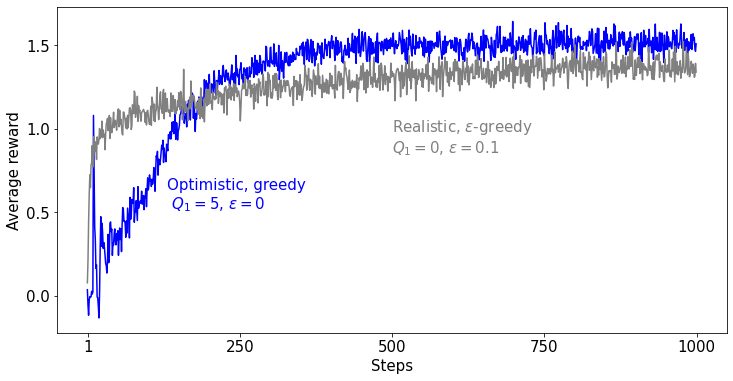

In [8]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize = (12, 6))
plt.plot(optim_reward_avg, 'b')
plt.text(130, 0.6, f'Optimistic, greedy\n $Q_1 = 5$, $\epsilon = 0$', fontsize=15, ha = 'left', va='center', color='b')
plt.plot(epsilon_reward_avg, 'grey')
plt.text(500, 0.95, f'Realistic, $\epsilon$-greedy\n$Q_1 = 0 $, $\epsilon = 0.1$', fontsize=15, ha = 'left', va='center', color='grey')
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Average reward', fontsize=15)
plt.xticks([1, 250, 500, 750, 1000])
plt.yticks([0, 0.5, 1, 1.5])
plt.show()

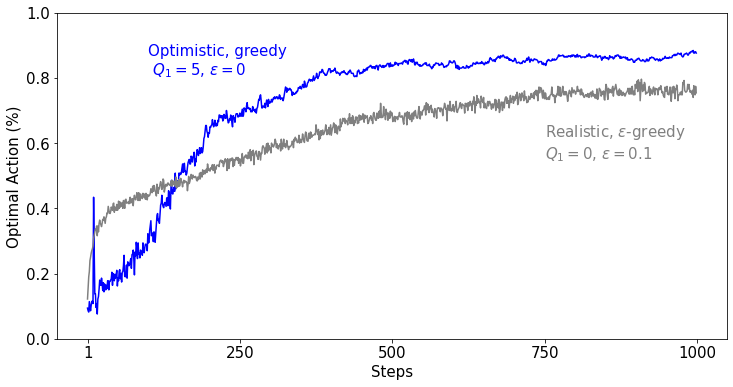

In [9]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize = (12, 6))
plt.plot(optim_action_avg, 'b')
plt.text(100, 0.85, f'Optimistic, greedy\n $Q_1 = 5$, $\epsilon = 0$', fontsize=15, ha = 'left', va='center', color='b')
plt.plot(epsilon_action_avg, 'grey')
plt.text(750, 0.6, f'Realistic, $\epsilon$-greedy\n$Q_1 = 0 $, $\epsilon = 0.1$', fontsize=15, ha = 'left', va='center', color='grey')
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Optimal Action (%)', fontsize=15)
plt.xticks([1, 250, 500, 750, 1000])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## UCB Algorithm

### Agent Class

In [10]:
class Agent():
    def __init__(self, n_action, initial_q_value = 0):
        self.n_action = n_action 
        self.initial_q_value = initial_q_value
        self.init_values()

    def init_values(self):
        # 실제 optimal q value 생성 
        self.pred_q_value_list = [self.initial_q_value for _ in range(self.n_action)]
        self.n_list = [0 for _ in range(self.n_action)]
        self.t = np.finfo(np.float32).eps
        self.c = 2

    def step(self, env, epsilon, exploration_mode = 'UCB'):
        '''
        한번의 time step 을 진행.
        
        '''
        # 1. epsilon 값에 따라 Action 선택 및 reward를 받음

        if exploration_mode == 'UCB': 
            action = self._get_UCB_action(self.t)
        elif epsilon > np.random.rand(1):            
            action = self._get_random_action()
        else : 
            action = self._get_greedy_action()
        
        reward = env.get_reward(action)

        # 2. n 값 증가 
        self.n_list[action] = self.n_list[action] + 1

        # 3. 선택된 Action의 Expected Reward 값 (q_value_list)을 업데이트. 
        self.pred_q_value_list[action] = self.pred_q_value_list[action] + (reward - self.pred_q_value_list[action]) / self.n_list[action]

        self.t = self.t + 1 
        return action, reward

    def _get_greedy_action(self):
        max_value = np.max(self.pred_q_value_list)
        max_actions = np.where(self.pred_q_value_list == max_value)[0]
        selected_action = np.random.choice(max_actions)
        return selected_action

    def _get_UCB_action(self, t):
        values = [q + self.c * np.sqrt(np.log(t) / n) for q, n in zip(self.pred_q_value_list, self.n_list)]
        action = np.argmax(values)
        return action

    def _get_random_action(self):
        random_action = np.random.randint(self.n_action)
        return random_action

### UCB Algorithm

In [11]:
# Run 
n_run = 2 # 2000
n_step = 1000
n_action = 10
env = Env(n_action)
agent = Agent(n_action)
epsilon = 0.0

In [12]:
def experiment(n_action, n_episode, n_step, epsilon=0.0, exploration_mode = 'random', initial_q_value = 0):
    env = Env(n_action)
    agent = Agent(n_action, initial_q_value)

    episode_reward_list = []
    episode_action_tf_list = []
    
    for run in tqdm(range(n_episode)):
        env.init_states()
        agent.init_values()
        best_action = np.argmax(env.optimal_q_value_list)
        
        reward_list = []
        action_tf_list = []
        for step in range(n_step):
            action, reward = agent.step(env, epsilon, exploration_mode = exploration_mode)
            
            reward_list.append(reward)        
            action_tf_list.append(action == best_action)
        
        episode_reward_list.append(reward_list)
        episode_action_tf_list.append(action_tf_list)
        
    return episode_reward_list, episode_action_tf_list

In [13]:
ucb_reward_list, ucb_action_list = experiment(n_action, n_episode=500, n_step = 1000, exploration_mode='UCB')
random_reward_list, random_action_list = experiment(n_action, n_episode=500, n_step = 1000, epsilon=0.1, exploration_mode='random')

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\cyun9\AppData\Local\Temp\ipykernel_24656\3242269981.py:56: RuntimeWarning: divide by zero encountered in true_divide
  values = [q + self.c * np.sqrt(np.log(t) / n) for q, n in zip(self.pred_q_value_list, self.n_list)]
C:\Users\cyun9\AppData\Local\Temp\ipykernel_24656\3242269981.py:56: RuntimeWarning: invalid value encountered in sqrt
  values = [q + self.c * np.sqrt(np.log(t) / n) for q, n in zip(self.pred_q_value_list, self.n_list)]
C:\Users\cyun9\AppData\Local\Temp\ipykernel_24656\3242269981.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  values = [q + self.c * np.sqrt(np.log(t) / n) for q, n in zip(self.pred_q_value_list, self.n_list)]
100%|██████████| 500/500 [00:18<00:00, 27.52it/s]


In [14]:
ucb_reward_pd = [pd.DataFrame(x) for x in ucb_reward_list]
random_reward_pd = [pd.DataFrame(x) for x in random_reward_list]

ucb_action_pd = [pd.DataFrame(x) for x in ucb_action_list]
random_action_pd = [pd.DataFrame(x) for x in random_action_list]

ucb_reward_avg = pd.concat(ucb_reward_pd, axis = 1).mean(axis=1)
random_reward_avg = pd.concat(random_reward_pd, axis = 1).mean(axis=1)

ucb_action_avg = pd.concat(ucb_action_pd, axis = 1).mean(axis=1)
random_action_avg = pd.concat(random_action_pd, axis = 1).mean(axis=1)

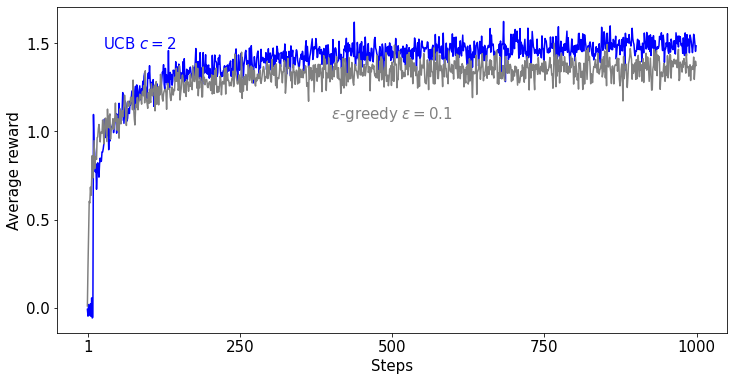

In [15]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize = (12, 6))
plt.plot(ucb_reward_avg, 'b')
plt.text(25, 1.5, 'UCB $c = 2$', fontsize=15, ha = 'left', va='center', color='b')
plt.plot(random_reward_avg, 'grey')
plt.text(400, 1.1, '$\epsilon$-greedy $\epsilon = 0.1$', fontsize=15, ha = 'left', va='center', color='grey')
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Average reward', fontsize=15)
plt.xticks([1, 250, 500, 750, 1000])
plt.yticks([0, 0.5, 1, 1.5])
plt.show()

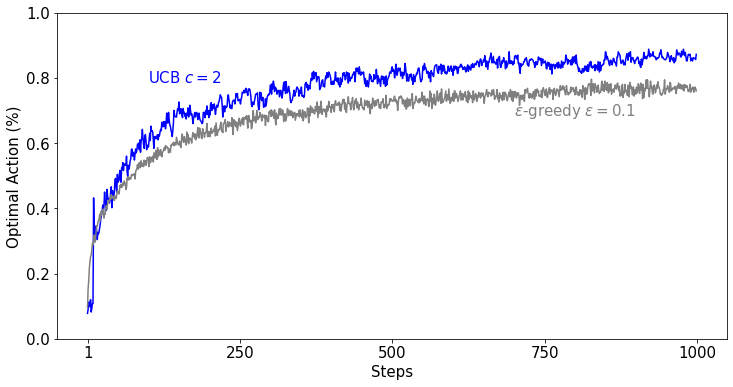

In [16]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize = (12, 6))
plt.plot(ucb_action_avg, 'b')
plt.text(100, 0.8, 'UCB $c = 2$', fontsize=15, ha = 'left', va='center', color='b')
plt.plot(random_action_avg, 'grey')
plt.text(700, 0.7, '$\epsilon$-greedy $\epsilon = 0.1$', fontsize=15, ha = 'left', va='center', color='grey')
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Optimal Action (%)', fontsize=15)
plt.xticks([1, 250, 500, 750, 1000])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()